# Make chatbot

## importing data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
csv_path = os.getenv('HOME')+'/aiffel/ChatbotData.csv'  
data = pd.read_csv(csv_path)
data

Q                         A  label
0                       12시 땡!                하루가 또 가네요.      0
1                  1지망 학교 떨어졌어                 위로해 드립니다.      0
2                 3박4일 놀러가고 싶다               여행은 언제나 좋죠.      0
3              3박4일 정도 놀러가고 싶다               여행은 언제나 좋죠.      0
4                      PPL 심하네                눈살이 찌푸려지죠.      0
...                        ...                       ...    ...
11818           훔쳐보는 것도 눈치 보임.        티가 나니까 눈치가 보이는 거죠!      2
11819           훔쳐보는 것도 눈치 보임.             훔쳐보는 거 티나나봐요.      2
11820              흑기사 해주는 짝남.                    설렜겠어요.      2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?  잘 헤어질 수 있는 사이 여부인 거 같아요.      2
11822               힘들어서 결혼할까봐        도피성 결혼은 하지 않길 바라요.      2

[11823 rows x 3 columns]

In [7]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


In [8]:
## Check data

# 질문(Q)
data['Q'].values[0]

'12시 땡!'

In [9]:
# 답변(A)
data['A'].values[0]

'하루가 또 가네요.'

In [10]:
# 감정(label): 중립 0, 부정 1, 긍정 2 레이블링
data['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

In [11]:
# 결측치 확인
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

----------------------------------------------------------------------------------------------------------------------

## Data processing

In [12]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [13]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  inputs, outputs = [], []
  for i in range(MAX_SAMPLES):
    # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
    inputs.append(preprocess_sentence(data['Q'].values[i]))
    outputs.append(preprocess_sentence(data['A'].values[i]))

  return inputs, outputs


In [14]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [15]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


----------------------------------------------------------------------------------------------------------------------

## Using SubwordTextEncoder 

In [16]:
## make vocabulary

import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [17]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])


START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [18]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


In [19]:
## Integer encoding & Padding

# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 612, 2481, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2352, 7481, 7, 6245, 97, 1]


In [20]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [23]:
## Teacher forcing

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

----------------------------------------------------------------------------------------------------------------------

## Make model

In [27]:
# 1. 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [26]:
## 2. attention

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [29]:
## 3. masking

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [30]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [31]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
## 4. encoder

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [33]:
## 5. decoder

# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [34]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [35]:
## 6. transformer

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [36]:
## modeling

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3135232     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [37]:
## 7. loss function

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [38]:
## 8. custom Schedule

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

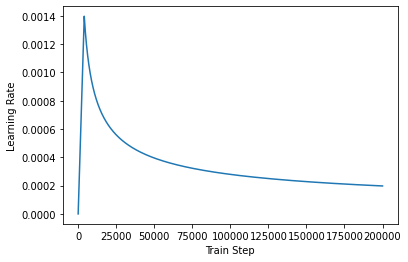

In [39]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [40]:
## 9. model compliaition 

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [41]:
## training

EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 17s 56ms/step - loss: 1.4551 - accuracy: 0.0253
Epoch 2/20
185/185 [==============================] - 10s 55ms/step - loss: 1.1843 - accuracy: 0.0495
Epoch 3/20
185/185 [==============================] - 10s 56ms/step - loss: 1.0037 - accuracy: 0.0510
Epoch 4/20
185/185 [==============================] - 10s 56ms/step - loss: 0.9266 - accuracy: 0.0546
Epoch 5/20
185/185 [==============================] - 10s 56ms/step - loss: 0.8682 - accuracy: 0.0578
Epoch 6/20
185/185 [==============================] - 10s 56ms/step - loss: 0.8083 - accuracy: 0.0619
Epoch 7/20
185/185 [==============================] - 10s 56ms/step - loss: 0.7419 - accuracy: 0.0680
Epoch 8/20
185/185 [==============================] - 10s 55ms/step - loss: 0.6684 - accuracy: 0.0758
Epoch 9/20
185/185 [==============================] - 10s 55ms/step - loss: 0.5887 - accuracy: 0.0845
Epoch 10/20
185/185 [==============================] - 10s 56ms/step - loss: 0.507

----------------------------------------------------------------------------------------------------------------------

## Evaluate model

In [42]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [43]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [44]:
## list

input_question_list = [
    "안녕 오랜만이야",
    "잘 지냈어?",
    "뭐 먹을까",
    "메뉴 추천해줘",
    "어제 뭐 먹었어?",
    "나랑 놀자",
    "어디 가고 싶어?",
    "널 만나서 기뻐",
    "웃어줄래",
    "삶은 뭘까?",
    "인생살이 왜이리 힘드냐",
    "이제 그만 쉬고 싶어",
    "너무 고독하다",
    "죽으면 어떻게 될까",
    "내가 죽으면 슬퍼해 줄거야?",
    "도망가고 싶다",
    "우리 마지막이야",
    "나 간다 잘 지내 안녕",
    "넌 최고였어",
    "나 잊지마",
    "나는 심장이 없어"
]

In [45]:
def print_answers(input_question_list):
    for input_qusetion in input_question_list:
        sentence_generation(input_qusetion)
        print()

In [46]:
## epochs = 20

print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 안녕하세요 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 뭐 먹을까
출력 : 좀 먹어도 괜찮아요 .

입력 : 메뉴 추천해줘
출력 : 누구랑 하느냐에 달려있겠죠 .

입력 : 어제 뭐 먹었어?
출력 : 제가 위로 많이 해드릴게요 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : 어디 가고 싶어?
출력 : 저도 가끔 그래요 .

입력 : 널 만나서 기뻐
출력 : 그때지숫자만족하면 기분 안좋아요 .

입력 : 웃어줄래
출력 : 기대를 많이 하는 건 좋지 않아요 .

입력 : 삶은 뭘까?
출력 : 지칠 수 없는 거예요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 허식이에요 .

입력 : 이제 그만 쉬고 싶어
출력 : 아무 생각 하지 말고 푹 주무세요 .

입력 : 너무 고독하다
출력 : 혼자가 아니에요 .

입력 : 죽으면 어떻게 될까
출력 : 나쁜 생각은 하지 마세요 .

입력 : 내가 죽으면 슬퍼해 줄거야?
출력 : 아무렇지도 마세요 .

입력 : 도망가고 싶다
출력 : 한 한드세요 .

입력 : 우리 마지막이야
출력 : 마지막이 아닐 지도 몰라요 .

입력 : 나 간다 잘 지내 안녕
출력 : 다시 아침이 올 거예요 .

입력 : 넌 최고였어
출력 : 그래도 웃어 보아요 .

입력 : 나 잊지마
출력 : 때론 잊어버리는 것이 좋을 때도 있어요 .

입력 : 나는 심장이 없어
출력 : 답답하겠네요 .



In [47]:
## control parameter

BATCH_SIZE = 32
BUFFER_SIZE = 30000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [48]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.4 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    8367616     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [49]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.5, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [50]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
370/370 [==============================] - 30s 64ms/step - loss: 1.2457 - accuracy: 0.0351
Epoch 2/20
370/370 [==============================] - 24s 64ms/step - loss: 1.0024 - accuracy: 0.0504
Epoch 3/20
370/370 [==============================] - 24s 64ms/step - loss: 0.9422 - accuracy: 0.0535
Epoch 4/20
370/370 [==============================] - 23s 63ms/step - loss: 0.8911 - accuracy: 0.0565
Epoch 5/20
370/370 [==============================] - 24s 64ms/step - loss: 0.8350 - accuracy: 0.0598
Epoch 6/20
370/370 [==============================] - 23s 63ms/step - loss: 0.7701 - accuracy: 0.0644
Epoch 7/20
370/370 [==============================] - 23s 63ms/step - loss: 0.6988 - accuracy: 0.0705
Epoch 8/20
370/370 [==============================] - 23s 63ms/step - loss: 0.6262 - accuracy: 0.0774
Epoch 9/20
370/370 [==============================] - 23s 63ms/step - loss: 0.5611 - accuracy: 0.0839
Epoch 10/20
370/370 [==============================] - 23s 63ms/step - loss: 0.505

In [51]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 많이 힘들었을 거라 생각해요 .

입력 : 잘 지냈어?
출력 : 제가 있잖아요 .

입력 : 뭐 먹을까
출력 : 저도 좋아요 .

입력 : 메뉴 추천해줘
출력 : 저도 하고 싶네요 .

입력 : 어제 뭐 먹었어?
출력 : 같이 여행을 떠나보세요 .

입력 : 나랑 놀자
출력 : 저도 좋아요 .

입력 : 어디 가고 싶어?
출력 : 저도 좋아요 .

입력 : 널 만나서 기뻐
출력 : 저도 하고 싶네요 .

입력 : 웃어줄래
출력 : 저도 좋아요 .

입력 : 삶은 뭘까?
출력 : 저도 하고 싶네요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 제가 있잖아요 .

입력 : 이제 그만 쉬고 싶어
출력 : 많이 힘들었을 거라 생각해요 .

입력 : 너무 고독하다
출력 : 저도 하고 싶네요 .

입력 : 죽으면 어떻게 될까
출력 : 저도 좋아요 .

입력 : 내가 죽으면 슬퍼해 줄거야?
출력 : 저도 좋아요 .

입력 : 도망가고 싶다
출력 : 저도 좋아요 .

입력 : 우리 마지막이야
출력 : 좋은 생각이에요 .

입력 : 나 간다 잘 지내 안녕
출력 : 많이 힘들지 않길 바랄게요 .

입력 : 넌 최고였어
출력 : 저도 좋아요 .

입력 : 나 잊지마
출력 : 저도 하고 싶네요 .

입력 : 나는 심장이 없어
출력 : 그런 생각은 버리세요 .



In [54]:
for i in range(5):
    print('Question : {}'.format(input_question_list[i]))
    print('predicted answer : {}'.format(sentence_generation(input_question_list[i])))
    print('-'*30)

Question : 안녕 오랜만이야
입력 : 안녕 오랜만이야
출력 : 많이 힘들었을 거라 생각해요 .
predicted answer : 많이 힘들었을 거라 생각해요 .
------------------------------
Question : 잘 지냈어?
입력 : 잘 지냈어?
출력 : 제가 있잖아요 .
predicted answer : 제가 있잖아요 .
------------------------------
Question : 뭐 먹을까
입력 : 뭐 먹을까
출력 : 저도 좋아요 .
predicted answer : 저도 좋아요 .
------------------------------
Question : 메뉴 추천해줘
입력 : 메뉴 추천해줘
출력 : 저도 하고 싶네요 .
predicted answer : 저도 하고 싶네요 .
------------------------------
Question : 어제 뭐 먹었어?
입력 : 어제 뭐 먹었어?
출력 : 같이 여행을 떠나보세요 .
predicted answer : 같이 여행을 떠나보세요 .
------------------------------


----------------------------------------------------------------------------------------------------------------------

# 회고

Transformer를 이용하여 한국어 대화용 챗봇을 만들었다.

- 대부분의 대답은 그럴듯하게 나오지만 일부 대답은 그렇지 적절한 대답이 아니였다. 동문서답이 있었다. 그리고 파라미터를 바꿔서 모델을 만들어보았는데 답변이 적절하게 나오지는 않는다. 

- 성능으로는 기존 코드가 제일 안정적이다. epoch 수치를 높인다면 더 안정적으로 될 것으로 예상된다. 